# Projeto P.I. U-Net Segmentation



In [1]:
!pip install brine-io

     |████████████████████████████████| 1.5MB 6.9MB/s 
  Stored in directory: /root/.cache/pip/wheels/54/91/5a/e77b1bf35cb71465f8768313307eb8e8ca432a34449ba716dd
  Stored in directory: /root/.cache/pip/wheels/9f/78/26/fb8c0acb91a100dc8914bf236c4eaa4b207cb876893c40b745
Successfully built brine-io bcolz


In [0]:
from google.colab import files

In [3]:
uploaded = files.upload()

Saving model.zip to model.zip
Saving weights.zip to weights.zip
Saving images.zip to images.zip


In [4]:
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

User uploaded file "model.zip" with length 4487 bytes
User uploaded file "weights.zip" with length 294 bytes
User uploaded file "images.zip" with length 5739915 bytes


In [5]:
!unzip model.zip

Archive:  model.zip
   creating: model/
  inflating: model/augmentations.py  
  inflating: model/losses.py         
  inflating: model/NOTICE            
  inflating: model/u_net.py          
 extracting: model/__init__.py       


In [6]:
!unzip weights.zip

Archive:  weights.zip
   creating: weights/
 extracting: weights/.gitkeep        


In [7]:
!unzip images.zip

Archive:  images.zip
   creating: images/
  inflating: images/annotations.csv  
  inflating: images/config.json      
 extracting: images/image1.png       
 extracting: images/image10.png      
  inflating: images/image10_mask.png  
 extracting: images/image11.png      
  inflating: images/image11_mask.png  
 extracting: images/image12.png      
  inflating: images/image12_mask.png  
 extracting: images/image13.png      
  inflating: images/image13_mask.png  
 extracting: images/image14.png      
  inflating: images/image14_mask.png  
 extracting: images/image15.png      
  inflating: images/image15_mask.png  
 extracting: images/image16.png      
  inflating: images/image16_mask.png  
 extracting: images/image17.png      
  inflating: images/image17_mask.png  
 extracting: images/image18.png      
  inflating: images/image18_mask.png  
  inflating: images/image19.png      
  inflating: images/image19_mask.png  
  inflating: images/image1_mask.png  
 extracting: images/image2.png      

In [8]:
%matplotlib inline
import brine
import cv2
import numpy as np
from model.augmentations import randomHueSaturationValue, randomShiftScaleRotate, randomHorizontalFlip
import model.u_net as unet
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
import matplotlib.pyplot as plt
from keras.preprocessing.image import img_to_array

Using TensorFlow backend.


# Carregando dataset


In [9]:
!brine build anas/my-images-with-masks --config images/config.json

  0% 0/42 [00:00<?, ? images/s]/usr/local/lib/python3.6/dist-packages/brine/builder.py:92: FutureWarning: A future version of pandas will default to `skipna=True`. To silence this warning, pass `skipna=True|False` explicitly.
  ctable = bcolz.ctable.fromdataframe(df, rootdir=os.path.join(destination_dir_path, 'bcolz'))
100% 42/42 [00:00<00:00, 1911.74 images/s]
Dataset anas/my-images-with-masks was built.


In [0]:
plants = brine.load_dataset('anas/my-images-with-masks')

In [11]:
print('Dataset size:', len(plants))
print('Columns:', plants.columns)
print(plants[3])

Dataset size: 21
Columns: Column(image=Column(name=image, type=Image), mask=Column(name=mask, type=Image))
Row(image='image4.png', mask='image4_mask.png')


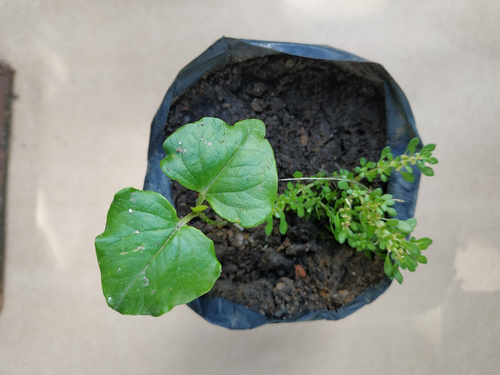

In [12]:
plants.load_image(plants[3].image)

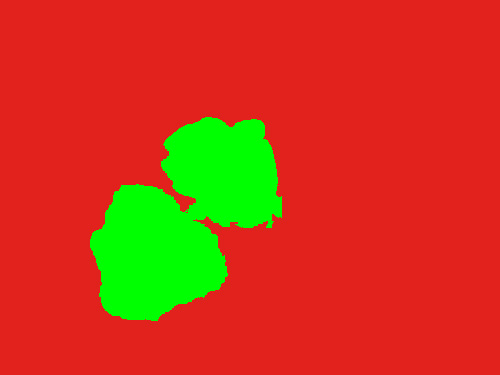

In [13]:
plants.load_image(plants[3].mask)

# Modelo

In [14]:
model = unet.get_unet_256(num_classes=1)
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 256, 256, 32) 128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 256, 256, 32) 0           batch_normalization_1[0][0]      
_____________________________________

In [0]:
SIZE = (256, 256)

In [0]:
def fix_mask(mask):
    mask[mask < 100] = 0.0
    mask[mask >= 100] = 255.0

In [0]:
def train_process(data):
    img, mask = data
    img = img[:,:,:3]
    mask = mask[:, :, :3]
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    fix_mask(mask)
    img = cv2.resize(img, SIZE)
    mask = cv2.resize(mask, SIZE)
    img = randomHueSaturationValue(img,
                                   hue_shift_limit=(-50, 50),
                                   sat_shift_limit=(0, 0),
                                   val_shift_limit=(-15, 15))
    img, mask = randomShiftScaleRotate(img, mask,
                                       shift_limit=(-0.0625, 0.0625),
                                       scale_limit=(-0.1, 0.1),
                                       rotate_limit=(-20, 20))
    img, mask = randomHorizontalFlip(img, mask)
    fix_mask(mask)
    img = img/255.
    mask = mask/255.
    mask = np.expand_dims(mask, axis=2)
    return (img, mask)

In [0]:
def validation_process(data):
    img, mask = data
    img = img[:,:,:3]
    mask = mask[:, :, :3]
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    fix_mask(mask)
    img = cv2.resize(img, SIZE)
    mask = cv2.resize(mask, SIZE)
    fix_mask(mask)
    img = img/255.
    mask = mask/255.
    mask = np.expand_dims(mask, axis=2)
    return (img, mask)

# Folds



In [0]:
BATCH_SIZE = 1

In [22]:
validation_fold, train_fold = plants.create_folds((7,))
print('Validation fold size:', len(validation_fold))
print('Train fold size:', len(train_fold))

Validation fold size: 7
Train fold size: 14


In [0]:
train_generator = train_fold.to_keras('image',  
                                      'mask',   
                                      batch_size=BATCH_SIZE,
                                      shuffle=True, 
                                      processing_function=train_process)

In [0]:
validation_generator = validation_fold.to_keras('image',
                                                'mask',
                                                batch_size=BATCH_SIZE,
                                                shuffle=False,
                                                processing_function=validation_process)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


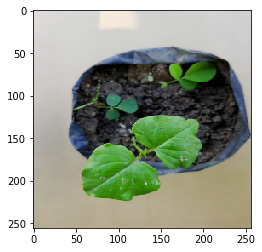

In [25]:
image, mask = next(train_generator)
plt.imshow(image[0])

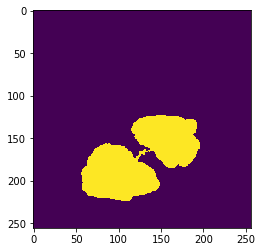

In [26]:
plt.imshow(mask[0].reshape(SIZE))

# Treinamento



In [27]:
callbacks = [EarlyStopping(monitor='val_loss',
                           patience=8,
                           verbose=1,
                           min_delta=1e-4),
             ReduceLROnPlateau(monitor='val_loss',
                               factor=0.1,
                               patience=4,
                               verbose=1,
                               epsilon=1e-4),
             ModelCheckpoint(monitor='val_loss',
                             filepath='weights/best_weights.hdf5',
                             save_best_only=True,
                             save_weights_only=True)]

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:1065: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


In [28]:
epochs=100
model.fit_generator(generator=train_generator,
                    steps_per_epoch=train_generator.steps_per_epoch(),
                    epochs=epochs,
                    callbacks=callbacks,
                    validation_data=validation_generator,
                    validation_steps=validation_generator.steps_per_epoch())

Instructions for updating:
Use tf.cast instead.
Epoch 1/100
14/14 [==============================] - 83s 6s/step - loss: 1.2928 - dice_coeff: 0.2978 - val_loss: 0.9928 - val_dice_coeff: 0.4188
Epoch 2/100
14/14 [==============================] - 74s 5s/step - loss: 0.9781 - dice_coeff: 0.3899 - val_loss: 0.9907 - val_dice_coeff: 0.4448
Epoch 3/100
14/14 [==============================] - 74s 5s/step - loss: 0.8531 - dice_coeff: 0.4313 - val_loss: 0.8869 - val_dice_coeff: 0.4546
Epoch 4/100
14/14 [==============================] - 73s 5s/step - loss: 0.8048 - dice_coeff: 0.4493 - val_loss: 0.8366 - val_dice_coeff: 0.4636
Epoch 5/100
14/14 [==============================] - 74s 5s/step - loss: 0.7797 - dice_coeff: 0.4578 - val_loss: 0.7952 - val_dice_coeff: 0.4759
Epoch 6/100
14/14 [==============================] - 73s 5s/step - loss: 0.7489 - dice_coeff: 0.4832 - val_loss: 3.0966 - val_dice_coeff: 0.4489
Epoch 7/100
14/14 [==============================] - 75s 5s/step - loss: 0.7539 - 

# Predições

In [0]:
model.load_weights('weights/best_weights.hdf5')

In [0]:
def predict_one():
    image_batch, mask_batch = next(validation_generator)
    predicted_mask_batch = model.predict(image_batch)
    #print(image_batch[0])
    image = image_batch[0]
    predicted_mask = predicted_mask_batch[0].reshape(SIZE)
    plt.imshow(image)
    plt.imshow(predicted_mask, alpha=0.6)

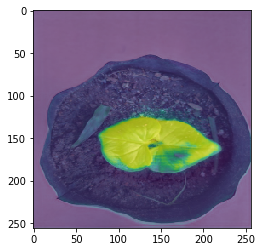

In [42]:
predict_one()